<a href="https://colab.research.google.com/github/ThesisCoacher/AppliedDeepLearningGroupWork/blob/master/House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle: 
**House Prices: Advanced Regression Techniques**

The content is split into the following steps:

1.   Import Data
2.   Preprocess Data
3.   Build the model
        a.)   Set up the layers
        b.)   Compile the model
4.   Train the model
5.   Evaluate accuracy
6.   Make predictions





In [0]:
# General imports:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


**1. Import Data**

The data we are using here is from a beginner task in Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. Essentially, we should be able to predict house prices based on an existing database. It contains 80 variables that can be used for input and 1 variable that is to be predicted (the price).

Let's first import it. To do so, I have loaded the datasets to 'Files/content' The following should include a document called 'train.csv':

In [0]:
!ls

sample_data  sample_submission.csv  submission.csv  test.csv  train.csv


Let's import that to a variable called 'train'.

In [0]:
train = pd.read_csv('./train.csv')
train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


There are 81 columns. 80 of these are possible features, while the last one is the label (i.e. the house prices). Let's now split the data into features (train) and labels (train_labels):

In [0]:
train_labels = train.pop('SalePrice')
train_labels.shape

(1460,)

In [0]:
train.shape

(1460, 80)

At this point we have split the training data into features and labels. However, the labels are continuous and the features contain many variables with barely any values in them. Many may also not make much sense when considering its price. We must therefore first preprocess the data.

**2. Preprocess Data**

Let's first remove the 'Id' feature, since this isn't really a feature and doesn't have anything to do with the price of the property:

In [0]:
train.pop('Id')
train.shape

(1460, 79)

This results in 79 possible features that are to be analyzed. Let's now look at missing data. As seen above, there are quite some rows with just 'NaN' in it. We probably don't want to use those. To check whether they are filled, we go ahead and count the number of times they are present per row and what that means in terms of percentage:

In [0]:
missing = pd.concat([train.isnull().sum(), train.isnull().sum() / train.shape[0]], axis=1, keys=['#NaN', '%-age'])
print(missing)

               #NaN     %-age
MSSubClass        0  0.000000
MSZoning          0  0.000000
LotFrontage     259  0.177397
LotArea           0  0.000000
Street            0  0.000000
Alley          1369  0.937671
LotShape          0  0.000000
LandContour       0  0.000000
Utilities         0  0.000000
LotConfig         0  0.000000
LandSlope         0  0.000000
Neighborhood      0  0.000000
Condition1        0  0.000000
Condition2        0  0.000000
BldgType          0  0.000000
HouseStyle        0  0.000000
OverallQual       0  0.000000
OverallCond       0  0.000000
YearBuilt         0  0.000000
YearRemodAdd      0  0.000000
RoofStyle         0  0.000000
RoofMatl          0  0.000000
Exterior1st       0  0.000000
Exterior2nd       0  0.000000
MasVnrType        8  0.005479
MasVnrArea        8  0.005479
ExterQual         0  0.000000
ExterCond         0  0.000000
Foundation        0  0.000000
BsmtQual         37  0.025342
...             ...       ...
HalfBath          0  0.000000
BedroomAbv

Looking at this data, we have a lot of cleaning up to do. Many columns of train have more missing than present values. Let's simply drop all columns with more than, say, 10% missing values. To do so, we find out which ones these are, and then use the .drop() method.

In [0]:
to_drop = missing[missing.sum(axis=1) > 0.1]
print(to_drop.index.tolist())

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [0]:
train.drop(to_drop.index.tolist(), axis=1, inplace=True)

train.shape

(1460, 60)

After sorting out which features are mostly empty and removing them, we are left with 60 features. Some of them may be more interesting than others. Also, since I have no idea how to handle text format input, I cancel these ones out. I looked for 'Object' dtypes and compiled a list of non-numeric (hence 'O'-type) entries. Next I will use this list to cancel out all the entries with 'O'- or object type content.

In [0]:
dtypes = train.dtypes
dtypes_nonnumeric = dtypes[dtypes == 'O']
dtypes_nonnumeric.index.tolist()

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'Functional',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [0]:
train.drop(dtypes_nonnumeric.index.tolist(), axis=1, inplace=True)
train.shape


(1460, 33)

Now we are left with 33 features. To find out, which ones of these may be related to each other (such that we really need only one of them), I look at the correlation of each pair of features. If the correlation is 0.75 or higher, I will erase one of the features.

In [0]:
corrmat = train.corr()
corrmat[corrmat.abs() > 0.75]

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotArea,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OverallQual,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OverallCond,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YearBuilt,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YearRemodAdd,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtFinSF1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtFinSF2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtUnfSF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalBsmtSF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,0.81953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


By doing so the above, we can easily see which ones correlate strongly:


*   TotalBsmtSF and 1stFlrSF
*   GarageCars and GarageArea
*   TotRmsAbvGrd and GrLivArea

I therefore erase one each, that is: ['1stFlrSF' , 'GarageCars', 'TotRmsAbvGrd']


In [0]:
to_delete = ['1stFlrSF' , 'GarageCars', 'TotRmsAbvGrd']
train.drop(to_delete, axis=1, inplace=True)

train.shape

(1460, 30)

That was not very successful. We still have 30 features. Lets add the sale price to the dataframe and redo this step. This time aiming at identifying the factors that don't correlate in either direction with the sales price - which we may wish to eliminate.

In [0]:
train_with_price = pd.concat([train, train_labels], axis=1)
train_with_price.head()

corrmat = train_with_price.corr()

In [0]:
low_corr = corrmat[corrmat.abs() < 0.3]
to_drop = low_corr['SalePrice']
to_drop_2 = to_drop[~np.isnan(to_drop)]
to_drop_2

MSSubClass      -0.084284
LotArea          0.263843
OverallCond     -0.077856
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
LowQualFinSF    -0.025606
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
Name: SalePrice, dtype: float64

In [0]:
to_drop_2.index.tolist()

['MSSubClass',
 'LotArea',
 'OverallCond',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

Having identified the above list to drop, we can remove it from the 'train' dataset:

In [0]:
train.drop(to_drop_2.index.tolist(), axis=1, inplace=True)
train.shape

(1460, 12)

This leaves us with 12 features. That seams reasonable. Let's therefore move on to the next task:

**3.   Build the model**

        a.)   Set up the layers
        b.)   Compile the model

As a next step we have to prepare the layers. We are using fully connected neural layers. Let's just pick some number of nodes for our first layer: 48. This represents the number of possible information transmitters to the next layer. Since we go for fully connected layers, each of these will take 12 inputs from the features and uses 12 individual weights (activation levels) - one for each feature.

The next layer will have 48 nodes too and then we want to get a single output value, that is: Sale Price.

The matrix formats are therefore:
[1460 x 12] [12 x 48] [48 x 1]

To set this up, we use tf.keras.layers.Dense for each layer:

Next we have to compile he model. To do so, we must define...


*   Loss function: How do we measure success to tell the model in which direction to go?
*   Optimizer: How is the model updated based on the data it sees and the loss function?
*   Metrics: what is used to monitor the training? (e.g. accuracy)



In [0]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(48, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    keras.layers.Dense(48, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])
  
  model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
             loss='mean_squared_error',
             metrics=['mean_absolute_error', 'mean_squared_error'])

  return model

model = build_model()

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                624       
_________________________________________________________________
dense_1 (Dense)              (None, 48)                2352      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 49        
Total params: 3,025
Trainable params: 3,025
Non-trainable params: 0
_________________________________________________________________


That should do it: We have defined a model with two 48 neuron layers, defined, and compiled the model and are now ready to train it.

**4. Train the Model**

Next: We can test the model first, maybe that reveals if there is some issue with the output values (shape or else).

In [0]:
example_batch = train[:10]
example_result = model.predict(example_batch)
example_result

array([[-164.23087 ],
       [ -75.07092 ],
       [-155.52042 ],
       [-149.84625 ],
       [-173.77817 ],
       [-142.92377 ],
       [-102.679474],
       [-165.85533 ],
       [-133.69942 ],
       [ -91.55632 ]], dtype=float32)

Apart from these values being pretty random, we can say that something we would expect comes out: a list of 10 numbers (for 10 sets) with floating point values. That's good so far. Let's train the model then:

In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  train, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,1.418091e+09,23790.259766,1.418091e+09,4.843149e+09,28461.535156,4.843149e+09,995
996,1.418924e+09,23838.056641,1.418924e+09,4.781696e+09,28455.978516,4.781695e+09,996
997,1.415042e+09,23829.054688,1.415042e+09,4.859751e+09,28450.021484,4.859751e+09,997
998,1.423622e+09,23929.902344,1.423622e+09,4.895710e+09,28560.570312,4.895710e+09,998
999,1.422496e+09,23774.369141,1.422496e+09,4.844230e+09,28459.263672,4.844230e+09,999


In [0]:
example_result = model.predict(example_batch)
example_result

array([[195465.42 ],
       [171797.73 ],
       [204295.02 ],
       [185291.16 ],
       [286417.3  ],
       [158014.17 ],
       [271726.84 ],
       [244085.44 ],
       [181463.95 ],
       [129909.914]], dtype=float32)

In [0]:
train.head()


,OverallQual,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,2ndFlrSF,GrLivArea,FullBath,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF
0,7,2003,2003,706,856,854,1710,2,0,548,0,61
1,6,1976,1976,978,1262,0,1262,2,1,460,298,0
2,7,2001,2002,486,920,866,1786,2,1,608,0,42
3,7,1915,1970,216,756,756,1717,1,1,642,0,35
4,8,2000,2000,655,1145,1053,2198,2,1,836,192,84


That's much better - at least when looking at the total value. Let's compare to the actual numbers:

In [0]:
for i in range(10):
  print(train_labels[i], example_result[i], "difference = ", train_labels[i] - example_result[i])

208500 [195465.42] difference =  [13034.578125]
181500 [171797.73] difference =  [9702.265625]
223500 [204295.02] difference =  [19204.984375]
140000 [185291.16] difference =  [-45291.15625]
250000 [286417.3] difference =  [-36417.3125]
143000 [158014.17] difference =  [-15014.171875]
307000 [271726.84] difference =  [35273.15625]
200000 [244085.44] difference =  [-44085.4375]
129900 [181463.95] difference =  [-51563.953125]
118000 [129909.914] difference =  [-11909.9140625]


That's allrady quite close. (I did the above with only 1000 epochs before, and this has cut the errors by a factor of about 4-6). More visually speaking, since we have tracked the history, this yields:

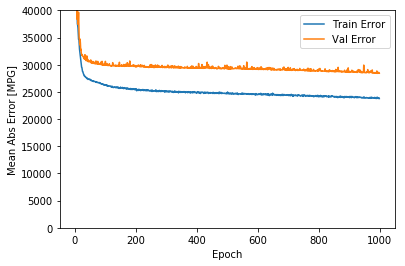

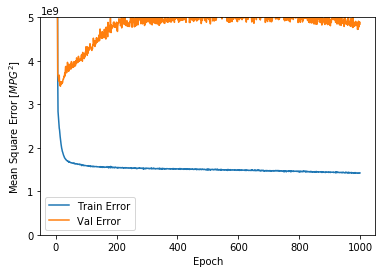

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,40000])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,5000000000])
  plt.legend()
  plt.show()


plot_history(history)


Looking at these, we might do better to just go for 4000 training epochs, considering the value errors are increasing thereafter. Still, let's go with this and finish the prediction task. To do so, we should now make sure that our program provides the right output. This is - as per sample_submission.csv looking like so:

In [0]:
infile = open('sample_submission.csv', "r")
for i in range(5):
  print(infile.readline())

infile.close()

Id,SalePrice

1461,169277.0524984

1462,187758.393988768

1463,183583.683569555

1464,179317.47751083



Let's thus figure out how to do that. We should use our model to predict the prices for what we can find in the test dataset (test.csv). Now, what would have been intelligent is to keep track of the changes made to the dataset. Since I did not, in fact, do so, I have to figure out ex-post, which columns I have deleted and treat the test set in the exact same manner. Otherwise, the model cannot map to the test data...

In [0]:
"""
1: split data (here: not necessary, since there are no SalePrice in the test set)
2: remove the index*: train.pop('Id') -> shape = 79,0
3: drop missing value infested columns** -> shape = 60,0.
4: drop non-numerics: (lost, got to redo...)
5: drop colinear features: ['1stFlrSF' , 'GarageCars', 'TotRmsAbvGrd'] -> shape = 30,0
6: drop some more: ['MSSubClass',
 'LotArea',
 'OverallCond',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']  -> shape = 12,0
 
 Well that's an awful way to find 12 items. Let's do it more simply and go
 with the features that are remembered by train..
 

*: well... Must keep them for later, but not in the model.
**: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
"""

features = train.columns.tolist()
features

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'Fireplaces',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF']

So, we have to open the test.csv file and manipulate it such that we only have the features we need/want in the dataframe:

In [0]:
test_data = pd.read_csv('./test.csv')
test_data.shape

In [0]:
test_data_curated = test_data[train.columns.tolist()]
test_data_curated.shape

Now that we have the curated input data, we simply have to make the predictions with the model and then somehow bring the results into a format that resembles our desired output.

In [0]:
test_result = model.predict(test_data_curated)

result_list_of_lists = test_result.tolist()
result_list = []

for result in result_list_of_lists:
  result_list.append(result[0])

results = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': result_list})

results


Let's make sure there is no nonsensical data: First off, if the 'SalesPrice' is negative, then that's no good. If there is no output value, that's no good either. We should fill those faulty ones with the mean, because - why not. 

In [0]:
stats = results.describe()
stats

In [0]:
results = results.replace(np.nan, stats['SalePrice']['mean'])

negatives = results[results['SalePrice'] < 0]

neg_values = negatives['SalePrice'].tolist()

for value in neg_values:
  results = results.replace(value, stats['SalePrice']['mean'])
  
stats_2 = results.describe()
stats_2

Now we must create a submission document - call it 'submission.csv', which features 'Id', and 'SalePrice' as column headers and all these items as content.

In [0]:
fout = open('./submission.csv', "w")

results.to_csv(fout, sep=',', header=True, index=False)